<a href="https://colab.research.google.com/github/s-choung/Research_utility/blob/main/3_GA_size_opt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing OCP pretrained models
written by S.Choung 18th Nov
This code is to test out OC models using OC pretrained models

## OCP installation

In [2]:
from google.colab import drive
import os

drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-cluster -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

if not os.path.exists('ocp'):
     !git clone https://github.com/Open-Catalyst-Project/ocp.git
os.chdir('ocp')
!pip install -e .
!pip -q install  lmdb pymatgen==2023.5.10 ase==3.22.1 orjson e3nn==0.2.6 wandb
!pip install submitit

import json,zipfile
import numpy as np
import pandas as pd
from tqdm import tqdm

from ase.io import read

from torch.nn.parallel import DistributedDataParallel as DDP
import torch.distributed as dist

from ocpmodels.datasets import SinglePointLmdbDataset
from ocpmodels.preprocessing import AtomsToGraphs
from ocpmodels.datasets import data_list_collater
from ocpmodels.common.relaxation.ase_utils import OCPCalculator
if torch.cuda.is_available():
    device = torch.device("cuda")

2.2.1+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 66.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 15.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Cloning into 'ocp'...
remote: Enumerating objects: 12634, done.
remote: Total 12634 (delta 0), reused 0 (delta 0), pack-reused 12634
Receiving objects: 100% (12634/12634), 172.76 MiB | 24.43 MiB/s, done.
Resolving deltas: 100% (8690/8690), done.
Obtaining file:///content/ocp
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for ocp-models (pyproject.toml) ... done
  Created wheel for ocp-models: filename=ocp_models-0.0.3-0.editable-

## load some useful utillities
 code taken from https://open-catalyst-project.github.io/tutorial/fine-tuning/fine-tuning-oxides.html

In [4]:
# @title
import urllib
import os
from pathlib import Path
import requests
# @title
import ocpmodels as om
from pathlib import Path
import subprocess
import sys
import numba
import numpy as np
import ase
import e3nn
import pymatgen.core as pc
import torch
import torch.cuda as tc
import torch_geometric as tg
import platform
import psutil

def ocp_root():
    """Return the root directory of the installed ocp package."""
    return Path(om.__file__).parent.parent

def ocp_main():
    """Return the path to ocp main.py"""
    return ocp_root() / "main.py"

def describe_ocp():
    """Print some system information that could be useful in debugging."""
    print(sys.executable, sys.version)
    print(f'ocp is installed at {ocp_root()}')

    commit_hash = (
            subprocess.check_output(
                    [
                        "git",
                        "-C",
                        om.__path__[0],
                        "describe",
                        "--always",
                    ]
                )
                .strip()
                .decode("ascii")
            )
    print(f'ocp repo is at git commit: {commit_hash}')
    print(f'numba: {numba.__version__}')
    print(f'numpy: {np.version.version}')
    print(f'ase: {ase.__version__}')
    print(f'e3nn: {e3nn.__version__}')
    print(f'pymatgen: {pc.__version__}')
    print(f'torch: {torch.version.__version__}')
    print(f'torch.version.cuda: {torch.version.cuda}')
    print(f'torch.cuda: is_available: {tc.is_available()}')
    if tc.is_available():
        print('  __CUDNN VERSION:', torch.backends.cudnn.version())
        print('  __Number CUDA Devices:', torch.cuda.device_count())
        print('  __CUDA Device Name:',torch.cuda.get_device_name(0))
        print('  __CUDA Device Total Memory [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)
    print(f'torch geometric: {tg.__version__}')
    print()
    print(f'Platform: {platform.platform()}')
    print(f'  Processor: {platform.processor()}')
    print(f'  Virtual memory: {psutil.virtual_memory()}')
    print(f'  Swap memory: {psutil.swap_memory()}')
    print(f'  Disk usage: {psutil.disk_usage("/")}')
checkpoints = {
    # Open Catalyst 2020 (OC20)
    'CGCNN 200k'	:'https://dl.fbaipublicfiles.com/opencatalystproject/models/2020_11/s2ef/cgcnn_200k.pt',
    'CGCNN 2M'	    :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2020_11/s2ef/cgcnn_2M.pt',
    'CGCNN 20M'	:'https://dl.fbaipublicfiles.com/opencatalystproject/models/2020_11/s2ef/cgcnn_20M.pt',
    'CGCNN All'	:'https://dl.fbaipublicfiles.com/opencatalystproject/models/2020_11/s2ef/cgcnn_all.pt',
    'DimeNet 200k'	:'https://dl.fbaipublicfiles.com/opencatalystproject/models/2020_11/s2ef/dimenet_200k.pt',
    'DimeNet 2M'	:'https://dl.fbaipublicfiles.com/opencatalystproject/models/2020_11/s2ef/dimenet_2M.pt',
    'SchNet 200k'	:'https://dl.fbaipublicfiles.com/opencatalystproject/models/2020_11/s2ef/schnet_200k.pt',
    'SchNet 2M'	    :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2020_11/s2ef/schnet_2M.pt',
    'SchNet 20M'	:'https://dl.fbaipublicfiles.com/opencatalystproject/models/2020_11/s2ef/schnet_20M.pt',
    'SchNet All'	:'https://dl.fbaipublicfiles.com/opencatalystproject/models/2020_11/s2ef/schnet_all_large.pt',
    'DimeNet++ 200k'   :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2021_02/s2ef/dimenetpp_200k.pt',
    'DimeNet++ 2M'     :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2021_02/s2ef/dimenetpp_2M.pt',
    'DimeNet++ 20M'    :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2021_02/s2ef/dimenetpp_20M.pt',
    'DimeNet++ All'    :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2021_02/s2ef/dimenetpp_all.pt',
    'SpinConv 2M'    :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2021_12/s2ef/spinconv_force_centric_2M.pt',
    'SpinConv All'    :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2021_08/s2ef/spinconv_force_centric_all.pt',
    'GemNet-dT 2M'    :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2021_12/s2ef/gemnet_t_direct_h512_2M.pt',
    'GemNet-dT All'    :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2021_08/s2ef/gemnet_t_direct_h512_all.pt',
    'PaiNN All'    :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2022_05/s2ef/painn_h512_s2ef_all.pt',
    'GemNet-OC 2M'     :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2022_07/s2ef/gemnet_oc_base_s2ef_2M.pt',
    'GemNet-OC All'    :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2022_07/s2ef/gemnet_oc_base_s2ef_all.pt',
    'GemNet-OC All+MD'    :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2023_03/s2ef/gemnet_oc_base_s2ef_all_md.pt',
    'GemNet-OC-Large All+MD' :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2022_07/s2ef/gemnet_oc_large_s2ef_all_md.pt',
    'SCN 2M'   :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2023_03/s2ef/scn_t1_b1_s2ef_2M.pt',
    'SCN-t4-b2 2M'    :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2023_03/s2ef/scn_t4_b2_s2ef_2M.pt',
    'SCN All+MD' :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2023_03/s2ef/scn_all_md_s2ef.pt',
    'eSCN-L4-M2-Lay12 2M'     :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2023_03/s2ef/escn_l4_m2_lay12_2M_s2ef.pt',
    'eSCN-L6-M2-Lay12 2M'    :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2023_03/s2ef/escn_l6_m2_lay12_2M_s2ef.pt',
    'eSCN-L6-M2-Lay12 All+MD'     :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2023_03/s2ef/escn_l6_m2_lay12_all_md_s2ef.pt',
    'eSCN-L6-M3-Lay20 All+MD'     :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2023_03/s2ef/escn_l6_m3_lay20_all_md_s2ef.pt',
    'EquiformerV2 (83M) 2M'     :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2023_06/oc20/s2ef/eq2_83M_2M.pt',
    'EquiformerV2 (31M) All+MD'     :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2023_06/oc20/s2ef/eq2_31M_ec4_allmd.pt',
    'EquiformerV2 (153M) All+MD'     :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2023_06/oc20/s2ef/eq2_153M_ec4_allmd.pt',
    # Open Catalyst 2022 (OC22)
    'GemNet-dT OC22'	: 'https://dl.fbaipublicfiles.com/opencatalystproject/models/2022_09/oc22/s2ef/gndt_oc22_all_s2ef.pt',
    'GemNet-OC OC22'	: 'https://dl.fbaipublicfiles.com/opencatalystproject/models/2022_09/oc22/s2ef/gnoc_oc22_all_s2ef.pt',
    'GemNet-OC OC20+OC22'	: 'https://dl.fbaipublicfiles.com/opencatalystproject/models/2022_09/oc22/s2ef/gnoc_oc22_oc20_all_s2ef.pt',
    'GemNet-OC trained with `enforce_max_neighbors_strictly=False` #467 OC20+OC22' : 'https://dl.fbaipublicfiles.com/opencatalystproject/models/2023_05/oc22/s2ef/gnoc_oc22_oc20_all_s2ef.pt',
    'GemNet-OC OC20->OC22'	: 'https://dl.fbaipublicfiles.com/opencatalystproject/models/2022_09/oc22/s2ef/gnoc_finetune_all_s2ef.pt',
    'equiformer' : 'https://dl.fbaipublicfiles.com/opencatalystproject/models/2023_10/oc22/s2ef/eq2_121M_e4_f100_oc22_s2ef.pt',
    'pt_ceo2_ce7_ep200' : '/content/drive/MyDrive/0_doctoral_project/1_pt_ceox/fine-tuning/checkpoints/2023-11-14-16-21-20-lr_5e-07_epochs_200/checkpoint.pt',
    'pt_ceo2_ce5_ep100_add' : '/content/drive/MyDrive/0_doctoral_project/1_pt_ceox/additional_data_training/2023-11-16-02-42-08-lr_0.0005_epochs_100/checkpoint.pt',
                }

def list_checkpoints():
    """List checkpoints that are available to download."""
    print('See https://github.com/Open-Catalyst-Project/ocp/blob/main/MODELS.md for more details.')
    for key in checkpoints:
        print(key)
    print('Copy one of these keys to get_checkpoint(key) to download it.')


def get_checkpoint(key):
    """Download a checkpoint.
    key: string in checkpoints.
    Returns name of checkpoint that was saved.
    """
    url = checkpoints.get(key, None)
    if url is None:
        raise Exception('No url found for {key}')
    print('url',url)
    pt = Path(urllib.parse.urlparse(url).path).name
    print('pt',pt)

    if not os.path.exists(pt):
        with open(pt, 'wb') as f:
            print(f'Downloading {url}')
            f.write(requests.get(url).content)
    return pt
from pathlib import Path
import numpy as np
from ase.db import connect

def train_test_val_split(ase_db, ttv=(0.8, 0.1, .1), files=('train.db', 'test.db', 'val.db'), seed=42):
    """Split an ase db into train, test and validation dbs.

    ase_db: path to an ase db containing all the data.
    ttv: a tuple containing the fraction of train, test and val data. This will be normalized.
    files: a tuple of filenames to write the splits into. An exception is raised if these exist.
           You should delete them first.
    seed: an integer for the random number generator seed

    Returns the absolute path to files.
    """

    for db in files:
        if os.path.exists(db):
            raise Exception('{db} exists. Please delete it before proceeding.')

    src = connect(ase_db)
    N = src.count()

    ttv = np.array(ttv)
    ttv /= ttv.sum()

    train_end = int(N * ttv[0])
    test_end = train_end + int(N * ttv[1])

    train = connect(files[0])
    test = connect(files[1])
    val = connect(files[2])

    ids = np.arange(1, N + 1)
    rng = np.random.default_rng(seed=42)
    rng.shuffle(ids)

    for _id in ids[0:train_end]:
        row = src.get(id=int(_id))
        train.write(row.toatoms())

    for _id in ids[train_end:test_end]:
        row = src.get(id=int(_id))
        test.write(row.toatoms())

    for _id in ids[test_end:]:
        row = src.get(id=int(_id))
        val.write(row.toatoms())

    return [Path(f).absolute() for f in files]
# @title
from yaml import load, dump
from yaml import CLoader as Loader, CDumper as Dumper
import torch
import os
from ocpmodels.common.relaxation.ase_utils import OCPCalculator
from io import StringIO
import sys
import contextlib

def generate_yml_config(checkpoint_path, yml='run.yml', delete=(), update=()):
    """Generate a yml config file from an existing checkpoint file.

    checkpoint_path: string to path of an existing checkpoint
    yml: name of file to write to.
    pop: list of keys to remove from the config
    update: dictionary of key:values to update

    Use a dot notation in update.

    Returns an absolute path to the generated yml file.
    """

    # You can't just read in the checkpoint with torch. The calculator does some things to it.
    # Rather than recreate that here I just reuse the calculator machinery. I don't want to
    # see the output though, so I capture it.

    with contextlib.redirect_stdout(StringIO()) as _:
        config = OCPCalculator(checkpoint_path=checkpoint_path).config # there seems an parameter checkpoint changed in OCPcalculator (s.choung)

    for key in delete:
        if key in config and len(key.split('.')) == 1:
            del config[key]
        else:
            keys = key.split('.')
            if keys[0] in config:
                d = config[keys[0]]
            else:
                continue
            if isinstance(d, dict):
                for k in keys[1:]:
                    if isinstance(d[k], dict):
                        d = d[k]
                    else:
                        if k in d:
                            del d[k]

    def nested_set(dic, keys, value):
        for key in keys[:-1]:
            dic = dic.setdefault(key, {})
        dic[keys[-1]] = value

    for _key in update:
        keys = _key.split('.')
        nested_set(config, keys, update[_key])


    out = dump(config)
    with open(yml, 'wb') as f:
        f.write(out.encode('utf-8'))

    return Path(yml).absolute()

### Load my calculator

In [5]:
from ase import Atoms
from ase.build import bulk
from ase.constraints import ExpCellFilter, StrainFilter
from ase.optimize import LBFGS, FIRE
from ase.io import Trajectory
import numpy as np
import pandas as pd
import requests
import pprint
import sys
import string
import json
import io
import copy
import ase.io
import ase.calculators.singlepoint
from ase.optimize import LBFGS
from ase.build import fcc111, molecule, add_adsorbate
from ase.constraints import ExpCellFilter, StrainFilter
from ocpmodels.common.relaxation.ase_utils import OCPCalculator
import json

gemnet_cal = OCPCalculator(checkpoint_path='/content/drive/MyDrive/1_multiscale/gnoc_oc22_oc20_all_s2ef.pt', cpu=False)


In [12]:
!sudo apt-get install povray  ## visulization program

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
povray is already the newest version (1:3.7.0.10-1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [13]:
import numpy as np
import pandas as pd
import requests
import pprint
import sys
import string
import json
import io
import copy
import ipywidgets as widgets
from IPython.display import display_png, Image as ImageWidget
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import shutil
import glob
from pathlib import Path
from PIL import Image, ImageDraw

def visual(structure, index, max_size=(100, 100), stretch_y=1.0,rotation='15z,-90x',png_save_path='hi'):
    renderer = write('./temp.pov', structure, rotation=rotation)
    renderer.render()
    image_path = f'./temp.png'
    img = Image.open(image_path)

    # Calculate new size with stretch factor
    new_size = (max_size[0], int(max_size[1] * stretch_y))
    img = img.resize(new_size, Image.LANCZOS)
    display(img)
    # Move files to output directory
    files = ['./temp.ini', './temp.pov', f'./temp.png']
    destination = './output/'

    # Ensure destination directory exists
    os.makedirs(destination, exist_ok=True)

    for file in files:
        # Remove the file in the destination directory if it exists
        if os.path.isfile(os.path.join(destination, os.path.basename(file))):
            os.remove(os.path.join(destination, os.path.basename(file)))

        # If the file is temp.png, rename it to index.png before moving
        if file == './temp.png':
            new_file_name = png_save_path+f'{index}.png'
        else:
            new_file_name = os.path.basename(file)
        shutil.move(file, os.path.join(destination, new_file_name))

In [16]:
from ase.io.vasp import read_vasp

path='/content/drive/MyDrive/1_multiscale/ga_input/'
slab=read_vasp(path+'100_S.vasp') # read_vasp('./POSCAR') 이런식으로도 가능.
print(slab) #slab이라는 atoms object를 읽어봄.
print(dir(slab)) # 아직 계산 전인 slab이라는 atoms object로 할 수 있는 일들 리스트를 뽑아봄.
# 'calc', 'cell', 'center', 'constraints', 'copy', 'edit', 'euler_rotate', 'extend', 'fromdict', 'get_all_distances', 'get_angle', 'get_angles', 'get_angular_momentum', 'get_array', 'get_atomic_numbers', 'get_calculator', 'get_cell', 'get_cell_lengths_and_angles', 'get_celldisp', 'get_center_of_mass', 'get_charges'
print("Number of atoms:", len(slab))
print("Chemical symbols:", slab.get_chemical_symbols())
print("Unit cell parameters (cell lengths and angles):", slab.cell)


Atoms(symbols='C36Mo72', pbc=True, cell=[[14.285174699999999, 0.0, 9e-16], [2.5e-15, 15.74964486, 1e-15], [0.0, 0.0, 24.34489796]], constraint=FixAtoms(indices=[0, 1, 4, 5, 6, 7, 12, 13, 16, 17, 18, 19, 24, 25, 28, 29, 30, 31, 36, 37, 40, 41, 42, 43, 48, 49, 52, 53, 54, 55, 60, 61, 64, 65, 66, 67, 72, 73, 76, 77, 78, 79, 84, 85, 88, 89, 90, 91, 96, 97, 100, 101, 102, 103]))
['__add__', '__class__', '__delattr__', '__delitem__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__iadd__', '__imul__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__mul__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_ase_handles_dynamic_stress', '_calc', '_celldisp', '_cellobj', '_centering_as_array', '_constraints', '_del_constraints', '_get_atomic_numbers', '_get_constraints', '_get_positi

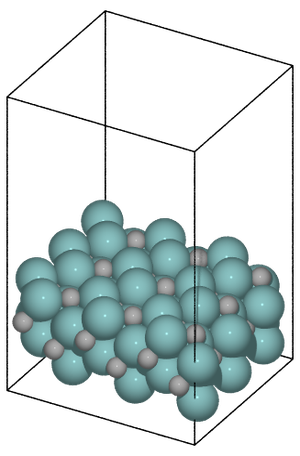

In [32]:
visual(slab, 'test', (300, 300),1.52,'60z,-60x','./')

Atomic numbers: [29 29 29 29]
Chemical symbols: ['Cu', 'Cu', 'Cu', 'Cu']
Positions: [[0.  0.  0. ]
 [0.  1.8 1.8]
 [1.8 0.  1.8]
 [1.8 1.8 0. ]]
Initial charges: [0. 0. 0. 0.]


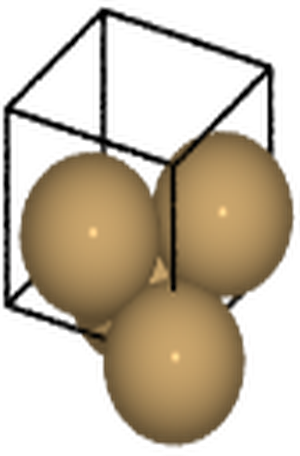

In [21]:
from ase.build import bulk, surface, molecule, add_adsorbate, fcc111


# Create a bulk copper (Cu) crystal
atoms = bulk('Cu', 'fcc', a=3.6, cubic=True)

print("Atomic numbers:", atoms.get_atomic_numbers())
print("Chemical symbols:", atoms.get_chemical_symbols())
print("Positions:", atoms.get_positions())
print("Initial charges:", atoms.get_initial_charges())
visual(atoms, 'test', (300, 300),1.52,'60z,-60x','./')


Atomic numbers: [28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28
 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28
 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28
 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28]
Chemical symbols: ['Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni']
Positions: [[ 1.25511454  0.72464072  0.        ]
 [ 3.76534361  0.72464072  0.        ]
 [ 0.  

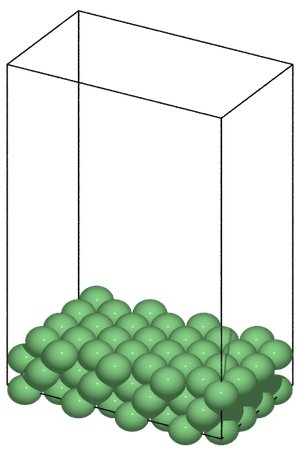

In [33]:
from ase.build import fcc111
atoms = fcc111('Ni', size=[2, 4, 3], a=3.55, orthogonal=True)
atoms.cell = [5.020458146424487, 8.695688586880282, 30.0]
atoms=atoms*(2,2,1)
print("Atomic numbers:", atoms.get_atomic_numbers())
print("Chemical symbols:", atoms.get_chemical_symbols())
print("Positions:", atoms.get_positions())
print("Initial charges:", atoms.get_initial_charges())
visual(atoms, 'test', (300, 300),1.52,'60z,-60x','./')


In [ ]:
def get_opt_energy(atoms, fmax=0.05, opt_mode: str = "normal"):

    return atoms.get_total_energy()

In [34]:
from ase import Atoms
from ase.build import bulk
from ase.constraints import ExpCellFilter, StrainFilter
from ase.optimize import LBFGS, FIRE
from ase.io import Trajectory
import numpy as np
import pandas as pd
import requests
import pprint
import sys
import string
import json
import io
import copy
import ase.io
import ase.calculators.singlepoint
from ase.optimize import LBFGS
from ase.build import fcc111, molecule, add_adsorbate
from ase.constraints import ExpCellFilter, StrainFilter
from ocpmodels.common.relaxation.ase_utils import OCPCalculator
import json

gemnet_cal = OCPCalculator(checkpoint_path='/content/drive/MyDrive/1_multiscale/gnoc_oc22_oc20_all_s2ef.pt', cpu=False)
calculator=gemnet_cal


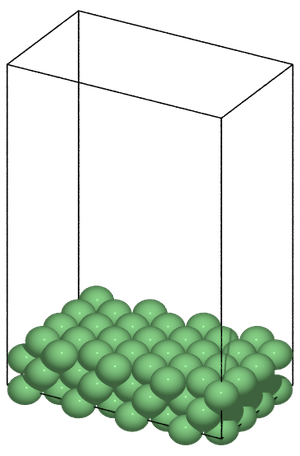

       Step     Time          Energy         fmax
LBFGS:    0 02:18:20     -433.584473        0.1323
LBFGS:    1 02:18:20     -433.459198        0.1150
LBFGS:    2 02:18:21     -433.130005        0.0552
LBFGS:    3 02:18:21     -432.845459        0.0059


True

In [35]:
visual(atoms, 'test', (300, 300),1.52,'60z,-60x','./')
tags = np.ones(len(atoms))
atoms.set_tags(tags)
atoms.set_calculator(calculator)
opt = LBFGS(atoms)
opt.run(fmax=0.05,steps=300)

In [37]:
print(atoms.get_total_energy())

-432.845458984375


Atomic numbers: [8 1 1]
Chemical symbols: ['O', 'H', 'H']
Positions: [[ 0.        0.        0.119262]
 [ 0.        0.763239 -0.477047]
 [ 0.       -0.763239 -0.477047]]
Initial charges: [0. 0. 0.]


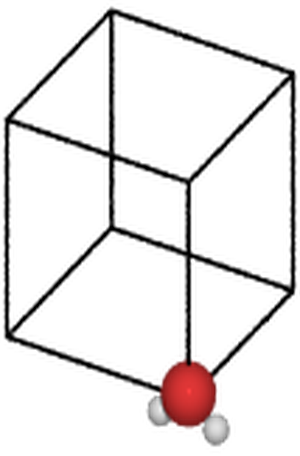

In [29]:
from ase.build import molecule

# Create a water (H2O) molecule
atoms = molecule('H2O')
atoms.cell = [5, 5, 5]

print("Atomic numbers:", atoms.get_atomic_numbers())
print("Chemical symbols:", atoms.get_chemical_symbols())
print("Positions:", atoms.get_positions())
print("Initial charges:", atoms.get_initial_charges())
visual(atoms, 'test', (300, 300),1.52,'60z,-60x','./')
